In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drunk-faces/README.dataset.txt
/kaggle/input/drunk-faces/README.roboflow.txt
/kaggle/input/drunk-faces/valid/Drunkface588B3_jpg.rf.a56b26720af701f86c92566c056e2501.jpg
/kaggle/input/drunk-faces/valid/Soberface531A1_jpg.rf.f942a348b4df874c3929da9d811f430c.jpg
/kaggle/input/drunk-faces/valid/Drunkface423B3_jpg.rf.e7885cd00ba50a33cc66248ac44e2196.jpg
/kaggle/input/drunk-faces/valid/Drunkface626B2_jpg.rf.2cf904a1477e8b25bc6db6bbb2d00d13.jpg
/kaggle/input/drunk-faces/valid/Soberface367A2_jpg.rf.d001cf55437b0a65bd789f2b94f7c767.jpg
/kaggle/input/drunk-faces/valid/Drunkface404B1_jpg.rf.0b348e03e7aa0eac23d695b30e9b0d4a.jpg
/kaggle/input/drunk-faces/valid/Soberface95A_jpg.rf.d537a17d382cb6741f39fc5f9e2f7b32.jpg
/kaggle/input/drunk-faces/valid/Drunkface48B2_jpg.rf.0c8a22897a8a081e5ced4f56713ec5f8.jpg
/kaggle/input/drunk-faces/valid/Drunkface400B3_jpg.rf.d4a65f6612f5a2440c69d75996d5a388.jpg
/kaggle/input/drunk-faces/valid/Soberface131A3_jpg.rf.334726f58411f8aa42a0f9bec038119a.jpg
/k

In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


2024-03-07 07:36:04.245473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 07:36:04.245587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 07:36:04.407448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_data(folder, annotations):
    data = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(folder, filename))
            img = img.resize((256, 256))  # Resize images to a fixed size
            data.append(np.array(img))
            label = annotations.loc[annotations['filename'] == filename]['class'].values[0]
            labels.append(label)
    return np.array(data), np.array(labels)

# Load annotations
train_annotations = pd.read_csv("/kaggle/input/drunk-faces/train/_annotations.csv")
test_annotations = pd.read_csv("/kaggle/input/drunk-faces/test/_annotations.csv")
val_annotations = pd.read_csv("/kaggle/input/drunk-faces/valid/_annotations.csv")

# Load data with equal number of images and labels
train_data, train_labels = load_data('/kaggle/input/drunk-faces/train', train_annotations)
test_data, test_labels = load_data('/kaggle/input/drunk-faces/test', test_annotations)
validation_data, validation_labels = load_data('/kaggle/input/drunk-faces/valid', val_annotations)


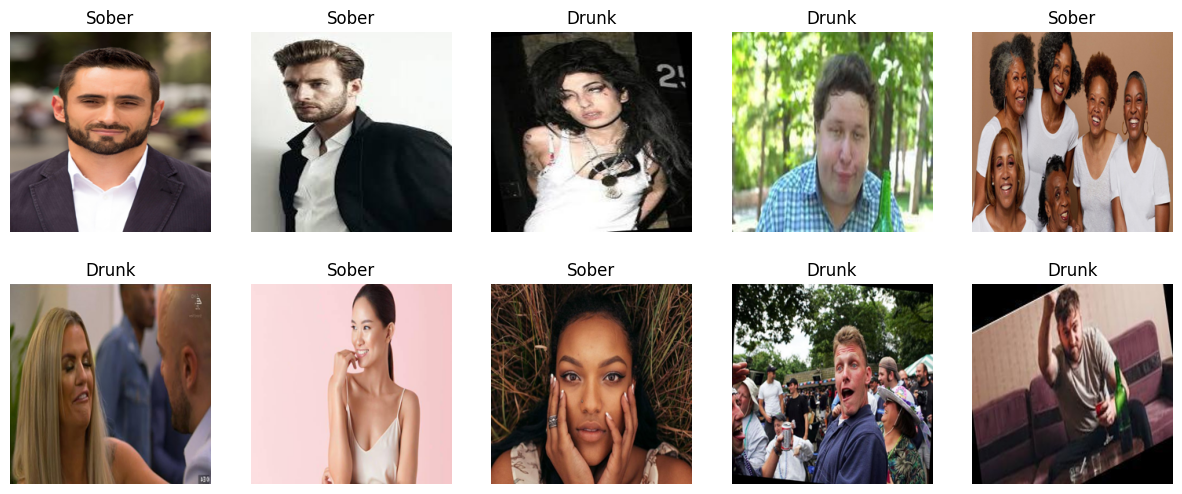

In [4]:
import matplotlib.pyplot as plt
class_labels = ['Drunk', 'Sober']

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_data[i])
    plt.title(train_labels[i]) 
    plt.axis('off')
plt.show()


In [5]:
train_data = train_data / 255.0
test_data = test_data / 255.0
validation_data = validation_data / 255.0

# Encode labels
# Convert labels to pandas Series
train_labels_series = pd.Series(train_labels)
test_labels_series = pd.Series(test_labels)
validation_labels_series = pd.Series(validation_labels)

# Replace labels
train_labels_series = train_labels_series.replace({'Drunk': 0, 'Sober': 1})
test_labels_series = test_labels_series.replace({'Drunk': 0, 'Sober': 1})
validation_labels_series = validation_labels_series.replace({'Drunk': 0, 'Sober': 1})

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels_series)
test_labels = label_encoder.transform(test_labels_series)
validation_labels = label_encoder.transform(validation_labels_series)


/tmp/ipykernel_27/3804067995.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels_series = train_labels_series.replace({'Drunk': 0, 'Sober': 1})
/tmp/ipykernel_27/3804067995.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels_series = test_labels_series.replace({'Drunk': 0, 'Sober': 1})
/tmp/ipykernel_27/3804067995.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To

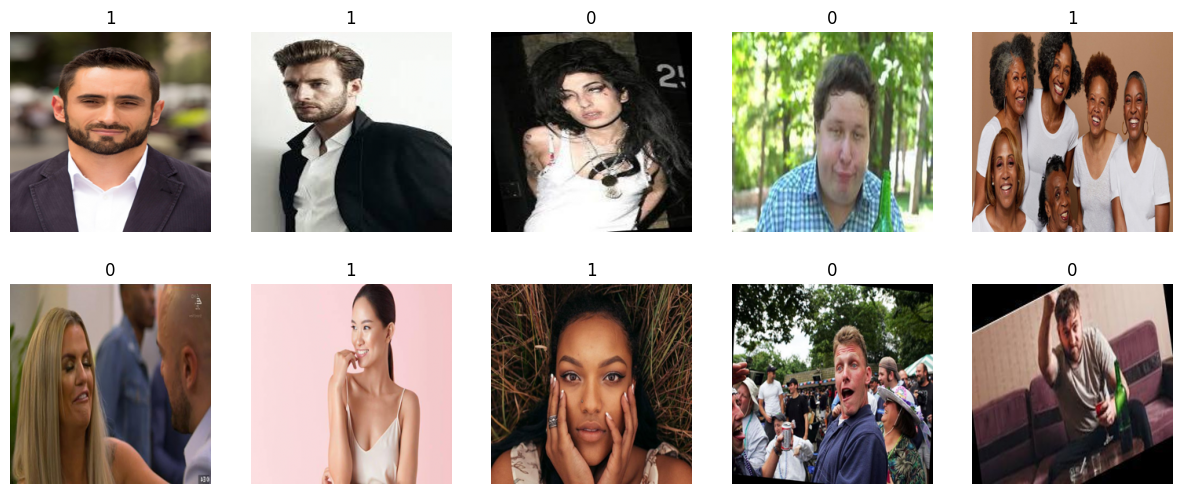

In [6]:
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_data[i])
    plt.title(train_labels[i]) 
    plt.axis('off')
plt.show()


In [7]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Validation data shape:", validation_data.shape)
print("Validation labels shape:", validation_labels.shape)


Train data shape: (3506, 256, 256, 3)
Train labels shape: (3506,)
Test data shape: (501, 256, 256, 3)
Test labels shape: (501,)
Validation data shape: (1001, 256, 256, 3)
Validation labels shape: (1001,)


In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [9]:
#model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(validation_data, validation_labels))


Epoch 1/10
  3/110 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4688 - loss: 1.9547

I0000 00:00:1709797068.000762      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709797068.020922      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6284 - loss: 0.8593

W0000 00:00:1709797085.161150      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.6289 - loss: 0.8574 - val_accuracy: 0.7622 - val_loss: 0.5078
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7558 - loss: 0.5007 - val_accuracy: 0.7682 - val_loss: 0.4899
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8204 - loss: 0.4165 - val_accuracy: 0.6983 - val_loss: 0.6904
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8240 - loss: 0.4008 - val_accuracy: 0.8022 - val_loss: 0.4568
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.8792 - loss: 0.2664 - val_accuracy: 0.7962 - val_loss: 0.4539
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9224 - loss: 0.1926 - val_accuracy: 0.7972 - val_loss: 0.4979
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9257 - loss: 0.1615 - val_accuracy: 0.8272 - val_loss: 0.5777
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9544 - loss: 0.1097 - val_accuracy: 0.8

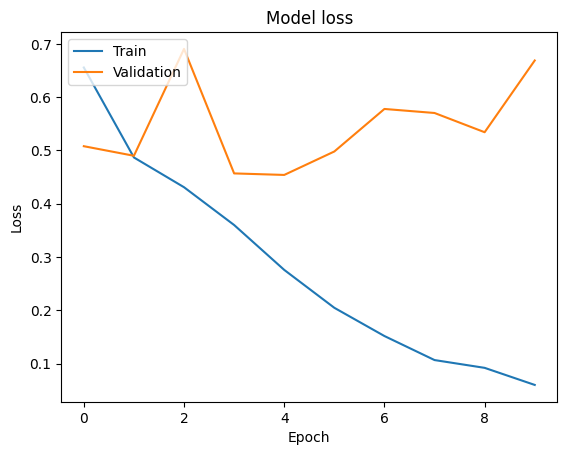

In [10]:
import matplotlib.pyplot as plt
history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(validation_data, validation_labels))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test Accuracy:', test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.8531 - loss: 0.4199
Test Accuracy: 0.8502994179725647


In [12]:
model.save("drunk_detector_model.h5")

In [13]:
import numpy as np
from keras.models import load_model
from PIL import Image

def load_data(image_path):
    img = Image.open(image_path)
    img = img.resize((256, 256))  # Resize image to match the input size of the model
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_image(model_path, image_path):
    # Load the saved model
    loaded_model = load_model(model_path)
    
    # Load and preprocess the image
    image = load_data(image_path)
    
    # Make predictions
    prediction = loaded_model.predict(image)
    
    # Interpret the prediction
    if prediction < 0.5:
        return "Drunk"
    else:
        return "Sober"

# Example usage:
#model_path = "drunk_detector_model.h5"
#image_path = "path_to_new_image.jpg"
#prediction = predict_image(model_path, image_path)
#print("Prediction:", prediction)
